<h1>**Table of Contents**<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Score-and-rank-properties-using-intrinsic-and-spatial-features" data-toc-modified-id="Score-and-rank-properties-using-intrinsic-and-spatial-features-1">Score and rank properties using intrinsic and spatial features</a></span><ul class="toc-item"><li><span><a href="#Read-spatially-enriched-properties" data-toc-modified-id="Read-spatially-enriched-properties-1.1">Read spatially enriched properties</a></span></li><li><span><a href="#Apply-weights" data-toc-modified-id="Apply-weights-1.2">Apply weights</a></span></li><li><span><a href="#Generate-scores-for-all-properties" data-toc-modified-id="Generate-scores-for-all-properties-1.3">Generate scores for all properties</a></span><ul class="toc-item"><li><span><a href="#Write-unscaled-data-to-disk" data-toc-modified-id="Write-unscaled-data-to-disk-1.3.1">Write unscaled data to disk</a></span></li></ul></li><li><span><a href="#Scale-data" data-toc-modified-id="Scale-data-1.4">Scale data</a></span><ul class="toc-item"><li><span><a href="#Apply-scores-on-scaled-data" data-toc-modified-id="Apply-scores-on-scaled-data-1.4.1">Apply scores on scaled data</a></span></li><li><span><a href="#Inverse-transform-data" data-toc-modified-id="Inverse-transform-data-1.4.2">Inverse transform data</a></span></li></ul></li><li><span><a href="#Sort-by-scores" data-toc-modified-id="Sort-by-scores-1.5">Sort by scores</a></span></li><li><span><a href="#Apply-a-rank-for-each-property-based-on-the-scores" data-toc-modified-id="Apply-a-rank-for-each-property-based-on-the-scores-1.6">Apply a rank for each property based on the scores</a></span></li><li><span><a href="#Visualize-the-top-50-properties" data-toc-modified-id="Visualize-the-top-50-properties-1.7">Visualize the top 50 properties</a></span><ul class="toc-item"><li><span><a href="#Investigate-statistical-distribution-facilities-in-the-top-50-shortlist" data-toc-modified-id="Investigate-statistical-distribution-facilities-in-the-top-50-shortlist-1.7.1">Investigate statistical distribution facilities in the top 50 shortlist</a></span></li><li><span><a href="#How-is-rank-correlated-with-location-properties-of-houses?" data-toc-modified-id="How-is-rank-correlated-with-location-properties-of-houses?-1.7.2">How is rank correlated with location properties of houses?</a></span></li><li><span><a href="#How-is-rank-correlated-with-intrinsic-properties-of-houses?" data-toc-modified-id="How-is-rank-correlated-with-intrinsic-properties-of-houses?-1.7.3">How is rank correlated with intrinsic properties of houses?</a></span></li><li><span><a href="#Save-to-disk" data-toc-modified-id="Save-to-disk-1.7.4">Save to disk</a></span></li></ul></li></ul></li></ul></div>

# Score and rank properties using intrinsic and spatial features
So far we have shortlisted properties based on their intrinsic properties such as number of rooms, price, HoA etc. We have enriched them with spatial attributes such as access to facilities and distance to a point of interest (such as work). In this notebook, we weigh and sum these attributes to produce a score for each property. We finally sort them to pick the top few.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
%matplotlib inline
import seaborn as sns

from arcgis.gis import GIS
from arcgis.features import Feature, FeatureLayer, FeatureSet, GeoAccessor, GeoSeriesAccessor

In [2]:
gis = GIS(profile='')

## Read spatially enriched properties

In [3]:
prop_df = pd.read_csv('resources/houses_facility_counts.csv')
prop_df = pd.DataFrame.spatial.from_xy(prop_df, 'LONGITUDE','LATITUDE')

In [19]:
prop_df.head()

,SALE TYPE,PROPERTY TYPE,ADDRESS,CITY,STATE,ZIP,PRICE,BEDS,BATHS,LOCATION,...,hospitals_count,coffee_count,bars_count,gas_count,shops_count,travel_count,parks_count,edu_count,commute_length,commute_duration
0,MLS Listing,Single Family Residential,144 SE 191st Pl,Portland,OR,97233.0,334900.0,4.0,2.5,"Gresham, Sandy, Troutdale, Corbett",...,0,19,0,28,41,50,50,50,13.978589,25.621265
1,MLS Listing,Single Family Residential,20028 NE Hoyt St,Portland,OR,97230.0,349950.0,3.0,2.5,Reeds Place,...,2,23,0,31,38,50,50,50,13.913465,24.726944
2,MLS Listing,Single Family Residential,711 SE 160th Ave,Portland,OR,97233.0,358999.0,4.0,2.5,Portland Southeast,...,0,16,0,34,47,50,50,50,14.644863,27.830024
3,MLS Listing,Single Family Residential,5536 SE 142nd Pl,Portland,OR,97236.0,369800.0,4.0,2.5,Portland Southeast,...,2,18,0,29,45,48,50,50,13.097669,25.943438
4,MLS Listing,Single Family Residential,15707 SE Flavel Dr,Portland,OR,97236.0,379900.0,3.0,2.0,Portland Southeast,...,0,13,0,17,44,10,50,41,14.254413,28.403598


In [20]:
prop_df.columns

Index(['SALE TYPE', 'PROPERTY TYPE', 'ADDRESS', 'CITY', 'STATE', 'ZIP',
       'PRICE', 'BEDS', 'BATHS', 'LOCATION', 'SQUARE FEET', 'LOT SIZE',
       'YEAR BUILT', 'DAYS ON MARKET', 'PRICE PER SQFT', 'HOA PER MONTH',
       'STATUS', 'URL', 'SOURCE', 'MLS', 'LATITUDE', 'LONGITUDE', 'SHAPE',
       'grocery_count', 'restaurant_count', 'hospitals_count', 'coffee_count',
       'bars_count', 'gas_count', 'shops_count', 'travel_count', 'parks_count',
       'edu_count', 'commute_length', 'commute_duration'],
      dtype='object')

Drop unnecessary columns

In [4]:
try:
    prop_df.drop(columns=['Unnamed: 0'], inplace=True)
    prop_df.drop(columns=['Unnamed: 0.1'], inplace=True)
except:
    pass

## Apply weights
In the following section, we determine the relative importance of each attribute and set weights accordingly

In [5]:
def set_scores(row):
    score = ((row['PRICE']*-1.5) + # penalize by 1.5 times
             (row['BEDS']*1)+
             (row['BATHS']*1)+
             (row['SQUARE FEET']*1)+
             (row['LOT SIZE']*1)+
             (row['YEAR BUILT']*1)+
             (row['HOA PER MONTH']*-1)+  # penalize by 1 times
             (row['grocery_count']*1)+
             (row['restaurant_count']*1)+
             (row['hospitals_count']*1.5)+  # reward by 1.5 times
             (row['coffee_count']*1)+
             (row['bars_count']*1)+
             (row['shops_count']*1)+
             (row['travel_count']*1.5)+  # reward by 1.5 times
             (row['parks_count']*1)+
             (row['edu_count']*1)+
             (row['commute_length']*-1)+  # penalize by 1 times
             (row['commute_duration']*-2)  # penalize by 2 times
            )
    return score

## Generate scores for all properties
We calculate the score for each property using the formula we defined in previous section

In [29]:
%%time
prop_df['scores'] = prop_df.apply(set_scores, axis=1)

CPU times: user 78 ms, sys: 1.98 ms, total: 80 ms
Wall time: 101 ms


In [30]:
prop_df.head()

,SALE TYPE,PROPERTY TYPE,ADDRESS,CITY,STATE,ZIP,PRICE,BEDS,BATHS,LOCATION,...,coffee_count,bars_count,gas_count,shops_count,travel_count,parks_count,edu_count,commute_length,commute_duration,scores
0,MLS Listing,Single Family Residential,144 SE 191st Pl,Portland,OR,97233.0,334900.0,4.0,2.5,"Gresham, Sandy, Troutdale, Corbett",...,19,0,28,41,50,50,50,13.978589,25.621265,-495439.721119
1,MLS Listing,Single Family Residential,20028 NE Hoyt St,Portland,OR,97230.0,349950.0,3.0,2.5,Reeds Place,...,23,0,31,38,50,50,50,13.913465,24.726944,-516614.867353
2,MLS Listing,Single Family Residential,711 SE 160th Ave,Portland,OR,97233.0,358999.0,4.0,2.5,Portland Southeast,...,16,0,34,47,50,50,50,14.644863,27.830024,-528948.304911
3,MLS Listing,Single Family Residential,5536 SE 142nd Pl,Portland,OR,97236.0,369800.0,4.0,2.5,Portland Southeast,...,18,0,29,45,48,50,50,13.097669,25.943438,-545169.484546
4,MLS Listing,Single Family Residential,15707 SE Flavel Dr,Portland,OR,97236.0,379900.0,3.0,2.0,Portland Southeast,...,13,0,17,44,10,50,41,14.254413,28.403598,-559115.061609


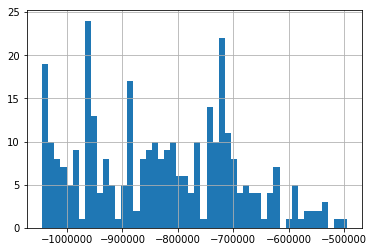

In [39]:
prop_df['scores'].hist(bins=50);   # trailing ; suppresses matplotlib's prints

/Users/atma6951/anaconda3/envs/geosaurus_gold/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


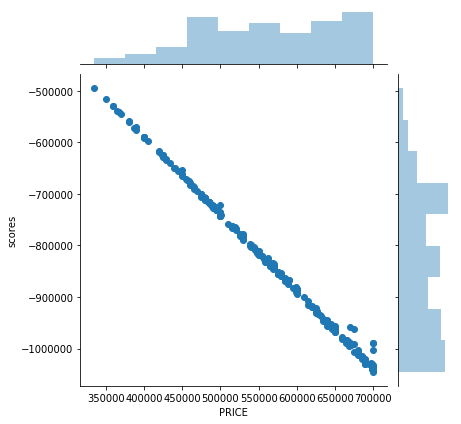

In [37]:
sns.jointplot('PRICE','scores', data=prop_df);

From the chart above, it appears numeric columns with large values (such as Price) weild an undue importance on our model. To rectify this, we need to scale all numeric columns and normalize them with each other. The section below performs this and then tries to generate scores based on the scaled values.

### Write unscaled data to disk

In [38]:
prop_df.to_csv('resources/houses_scores_unscaled.csv')

## Scale data
Although price plays an important role while selecting properties, the range and valuds of the `PRICE` column is much larger than any other. Thus, it influences more than its fair share. To resolve this, we scale the data using different techniques.

In [6]:
from sklearn.preprocessing import MinMaxScaler
mm_scaler = MinMaxScaler()

In [7]:
prop_df.columns

Index(['SALE TYPE', 'PROPERTY TYPE', 'ADDRESS', 'CITY', 'STATE', 'ZIP',
       'PRICE', 'BEDS', 'BATHS', 'LOCATION', 'SQUARE FEET', 'LOT SIZE',
       'YEAR BUILT', 'DAYS ON MARKET', 'PRICE PER SQFT', 'HOA PER MONTH',
       'STATUS', 'URL', 'SOURCE', 'MLS', 'LATITUDE', 'LONGITUDE', 'SHAPE',
       'grocery_count', 'restaurant_count', 'hospitals_count', 'coffee_count',
       'bars_count', 'gas_count', 'shops_count', 'travel_count', 'parks_count',
       'edu_count', 'commute_length', 'commute_duration'],
      dtype='object')

In [8]:
columns_to_scale = ['PRICE', 'BEDS', 'BATHS', 'SQUARE FEET', 'LOT SIZE',
       'YEAR BUILT', 'HOA PER MONTH','grocery_count', 'restaurant_count', 'hospitals_count', 'coffee_count',
       'bars_count', 'gas_count', 'shops_count', 'travel_count', 'parks_count',
       'edu_count', 'commute_length', 'commute_duration']

In [9]:
scaled_array = mm_scaler.fit_transform(prop_df[columns_to_scale])
prop_scaled = pd.DataFrame(scaled_array, columns=columns_to_scale)
prop_scaled.head()

,PRICE,BEDS,BATHS,SQUARE FEET,LOT SIZE,YEAR BUILT,HOA PER MONTH,grocery_count,restaurant_count,hospitals_count,coffee_count,bars_count,gas_count,shops_count,travel_count,parks_count,edu_count,commute_length,commute_duration
0,0.000000,0.333333,0.1,0.016024,0.023259,0.368421,0.00,1.0,1.0,0.000000,0.38,0.0,0.56,0.82,1.00,1.0,1.00,0.005581,0.009332
1,0.041222,0.166667,0.1,0.049981,0.046518,0.315789,0.00,1.0,1.0,0.166667,0.46,0.0,0.62,0.76,1.00,1.0,1.00,0.005553,0.008905
2,0.066007,0.333333,0.1,0.028233,0.069777,0.157895,0.00,1.0,1.0,0.000000,0.32,0.0,0.68,0.94,1.00,1.0,1.00,0.005865,0.010386
3,0.095590,0.333333,0.1,0.014498,0.069777,0.736842,0.00,1.0,1.0,0.166667,0.36,0.0,0.58,0.90,0.96,1.0,1.00,0.005204,0.009486
4,0.123254,0.166667,0.0,0.025181,0.093036,0.000000,0.17,1.0,1.0,0.000000,0.26,0.0,0.34,0.88,0.20,1.0,0.82,0.005698,0.010660


### Apply scores on scaled data

In [10]:
prop_scaled['scores_scaled'] = prop_scaled.apply(set_scores, axis=1)

Check the influence of price on scores

/Users/atma6951/anaconda3/envs/geosaurus_gold/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


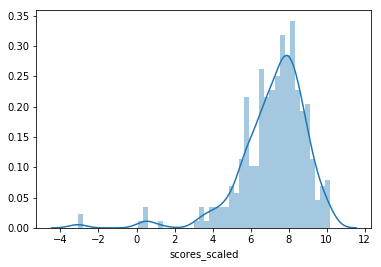

In [12]:
sns.distplot(prop_scaled['scores_scaled'], bins=50)

/Users/atma6951/anaconda3/envs/geosaurus_gold/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


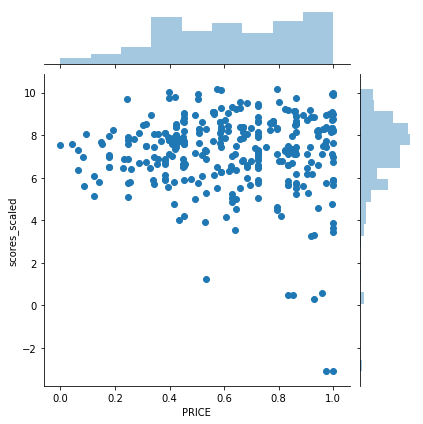

In [13]:
sns.jointplot(x='PRICE', y='scores_scaled', data=prop_scaled)

![](resources/effect-of-scaling.jpg)

After scaling, the scatter plot of `PRICE` VS `SCORES` appears random without much correlation. The histogram of scores also looks normally distributed. This is important as we want to consider all aspects of a house and weigh them according to their relative importance to the buyer. It is not much of a model if the scores are entirely based off one attribute (such as PRICE).

### Inverse transform data
Since we made a copy of the DataFrame when we scaled, we don't need to inverse transfrom the scaled data. We can simply copy the `scaled_scores` from this DataFrame and apply that to the original DataFrame

In [13]:
prop_df['scores_scaled'] = prop_scaled['scores_scaled']
prop_df.head()

,SALE TYPE,PROPERTY TYPE,ADDRESS,CITY,STATE,ZIP,PRICE,BEDS,BATHS,LOCATION,...,coffee_count,bars_count,gas_count,shops_count,travel_count,parks_count,edu_count,commute_length,commute_duration,scores_scaled
0,MLS Listing,Single Family Residential,144 SE 191st Pl,Portland,OR,97233.0,334900.0,4.0,2.5,"Gresham, Sandy, Troutdale, Corbett",...,19,0,28,41,50,50,50,13.978589,25.621265,7.516793
1,MLS Listing,Single Family Residential,20028 NE Hoyt St,Portland,OR,97230.0,349950.0,3.0,2.5,Reeds Place,...,23,0,31,38,50,50,50,13.913465,24.726944,7.563760
2,MLS Listing,Single Family Residential,711 SE 160th Ave,Portland,OR,97233.0,358999.0,4.0,2.5,Portland Southeast,...,16,0,34,47,50,50,50,14.644863,27.830024,7.323591
3,MLS Listing,Single Family Residential,5536 SE 142nd Pl,Portland,OR,97236.0,369800.0,4.0,2.5,Portland Southeast,...,18,0,29,45,48,50,50,13.097669,25.943438,8.036890
4,MLS Listing,Single Family Residential,15707 SE Flavel Dr,Portland,OR,97236.0,379900.0,3.0,2.0,Portland Southeast,...,13,0,17,44,10,50,41,14.254413,28.403598,5.162985


/Users/atma6951/anaconda3/envs/geosaurus_gold/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


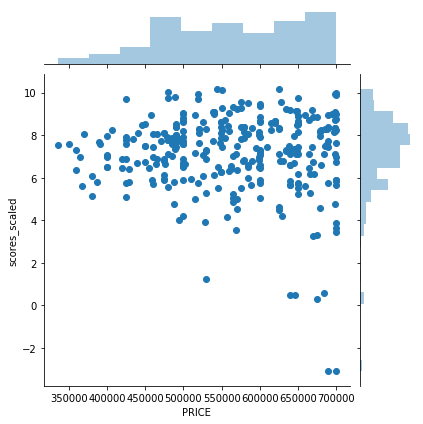

In [14]:
sns.jointplot('PRICE', 'scores_scaled', data=prop_df)

## Sort by scores

In [15]:
prop_df_sorted = prop_df.sort_values(by='scores_scaled', ascending=False)
prop_df_sorted.head(3)

,SALE TYPE,PROPERTY TYPE,ADDRESS,CITY,STATE,ZIP,PRICE,BEDS,BATHS,LOCATION,...,coffee_count,bars_count,gas_count,shops_count,travel_count,parks_count,edu_count,commute_length,commute_duration,scores_scaled
87,MLS Listing,Single Family Residential,15986 SE Spokane Ct. Ave,Portland,OR,97236.0,543900.0,4.0,3.5,Portland Southeast,...,50,2,34,46,50,50,50,5.796321,16.509734,10.179443
170,MLS Listing,Multi-Family (2-4 Unit),SE Henderson St,Portland,OR,97206.0,625000.0,6.0,6.0,LENTS,...,50,1,50,40,50,50,50,8.380589,23.087985,10.174764
101,MLS Listing,Single Family Residential,8268 SE Yamhill St,Portland,OR,97216.0,550000.0,7.0,4.0,Portland Southeast,...,50,1,50,43,50,50,50,6.330796,16.910622,10.140356


In [16]:
prop_df_sorted.reset_index(drop=True, inplace=True)
prop_df_sorted.head()

,SALE TYPE,PROPERTY TYPE,ADDRESS,CITY,STATE,ZIP,PRICE,BEDS,BATHS,LOCATION,...,coffee_count,bars_count,gas_count,shops_count,travel_count,parks_count,edu_count,commute_length,commute_duration,scores_scaled
0,MLS Listing,Single Family Residential,15986 SE Spokane Ct. Ave,Portland,OR,97236.0,543900.0,4.0,3.5,Portland Southeast,...,50,2,34,46,50,50,50,5.796321,16.509734,10.179443
1,MLS Listing,Multi-Family (2-4 Unit),SE Henderson St,Portland,OR,97206.0,625000.0,6.0,6.0,LENTS,...,50,1,50,40,50,50,50,8.380589,23.087985,10.174764
2,MLS Listing,Single Family Residential,8268 SE Yamhill St,Portland,OR,97216.0,550000.0,7.0,4.0,Portland Southeast,...,50,1,50,43,50,50,50,6.330796,16.910622,10.140356
3,MLS Listing,Single Family Residential,6311 SE Tenino St,Portland,OR,97206.0,479900.0,4.0,2.5,Portland Southeast,...,50,2,44,48,50,50,50,7.299694,20.389635,10.035397
4,MLS Listing,Multi-Family (2-4 Unit),2028 SE Harold St,Portland,OR,97202.0,699900.0,5.0,4.0,SELLWOOD - WEST MORELAND,...,50,2,40,45,50,50,50,3.710354,11.486135,9.958218


## Apply a rank for each property based on the scores

In [18]:
prop_df_sorted['rank'] = prop_df_sorted.index
prop_df_sorted.head(10)

,SALE TYPE,PROPERTY TYPE,ADDRESS,CITY,STATE,ZIP,PRICE,BEDS,BATHS,LOCATION,...,bars_count,gas_count,shops_count,travel_count,parks_count,edu_count,commute_length,commute_duration,scores_scaled,rank
0,MLS Listing,Single Family Residential,15986 SE Spokane Ct. Ave,Portland,OR,97236.0,543900.0,4.0,3.5,Portland Southeast,...,2,34,46,50,50,50,5.796321,16.509734,10.179443,0
1,MLS Listing,Multi-Family (2-4 Unit),SE Henderson St,Portland,OR,97206.0,625000.0,6.0,6.0,LENTS,...,1,50,40,50,50,50,8.380589,23.087985,10.174764,1
2,MLS Listing,Single Family Residential,8268 SE Yamhill St,Portland,OR,97216.0,550000.0,7.0,4.0,Portland Southeast,...,1,50,43,50,50,50,6.330796,16.910622,10.140356,2
3,MLS Listing,Single Family Residential,6311 SE Tenino St,Portland,OR,97206.0,479900.0,4.0,2.5,Portland Southeast,...,2,44,48,50,50,50,7.299694,20.389635,10.035397,3
4,MLS Listing,Multi-Family (2-4 Unit),2028 SE Harold St,Portland,OR,97202.0,699900.0,5.0,4.0,SELLWOOD - WEST MORELAND,...,2,40,45,50,50,50,3.710354,11.486135,9.958218,4
5,New Construction Home,Single Family Residential,16010 SE Spokane Ct,Portland,OR,97236.0,518750.0,3.0,2.5,Peach Tree Meadows,...,2,34,46,50,50,50,5.796321,16.509734,9.929172,5
6,MLS Listing,Multi-Family (2-4 Unit),5850 SE 86th Ave,Portland,OR,97266.0,699000.0,6.0,6.0,LENTS,...,1,50,38,50,50,50,10.899918,21.144505,9.924611,6
7,MLS Listing,Townhouse,2022 SE Harold St,Portland,OR,97202.0,699900.0,5.0,4.0,SELLWOOD - WEST MORELAND,...,2,40,45,50,50,50,3.713178,11.513058,9.880673,7
8,MLS Listing,Single Family Residential,15965 SE Spokane Ct,Portland,OR,97236.0,488750.0,3.0,2.5,Portland Southeast,...,2,34,46,50,50,50,5.796321,16.509734,9.794684,8
9,MLS Listing,Single Family Residential,16136 SE Tenino St,Portland,OR,97236.0,479900.0,3.0,2.5,Portland Southeast,...,2,36,46,50,50,50,4.998670,13.217221,9.761623,9


## Visualize the top 50 properties

In [29]:
top_10_map = gis.map('Portland, OR')
top_10_map.basemap = 'gray'
top_10_map

MapView(basemap='gray', layout=Layout(height='400px', width='100%'))

![](resources/map11.png)

In [39]:
prop_df_sorted.head(50).spatial.plot(map_widget = top_10_map, 
                      renderer_type='c',
                     method='esriClassifyNaturalBreaks',  # classification scheme
                     class_count=10,  # between 1900 - 2000, each decade in a class
                     col='scores_scaled',
                     cmap='autumn',  # matplotlib color map
                     alpha=0.7,
                     outline_color=[0,0,0,0])

/Users/atma6951/anaconda3/envs/geosaurus_gold/lib/python3.6/site-packages/arcgis/features/geo/_accessor.py:861: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._data[col] = self._data[col]
/Users/atma6951/anaconda3/envs/geosaurus_gold/lib/python3.6/site-packages/arcgis/features/geo/_accessor.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._data['OBJECTID'] = list(range(1, self._data.shape[0] + 1))


True

### Investigate statistical distribution facilities in the top 50 shortlist

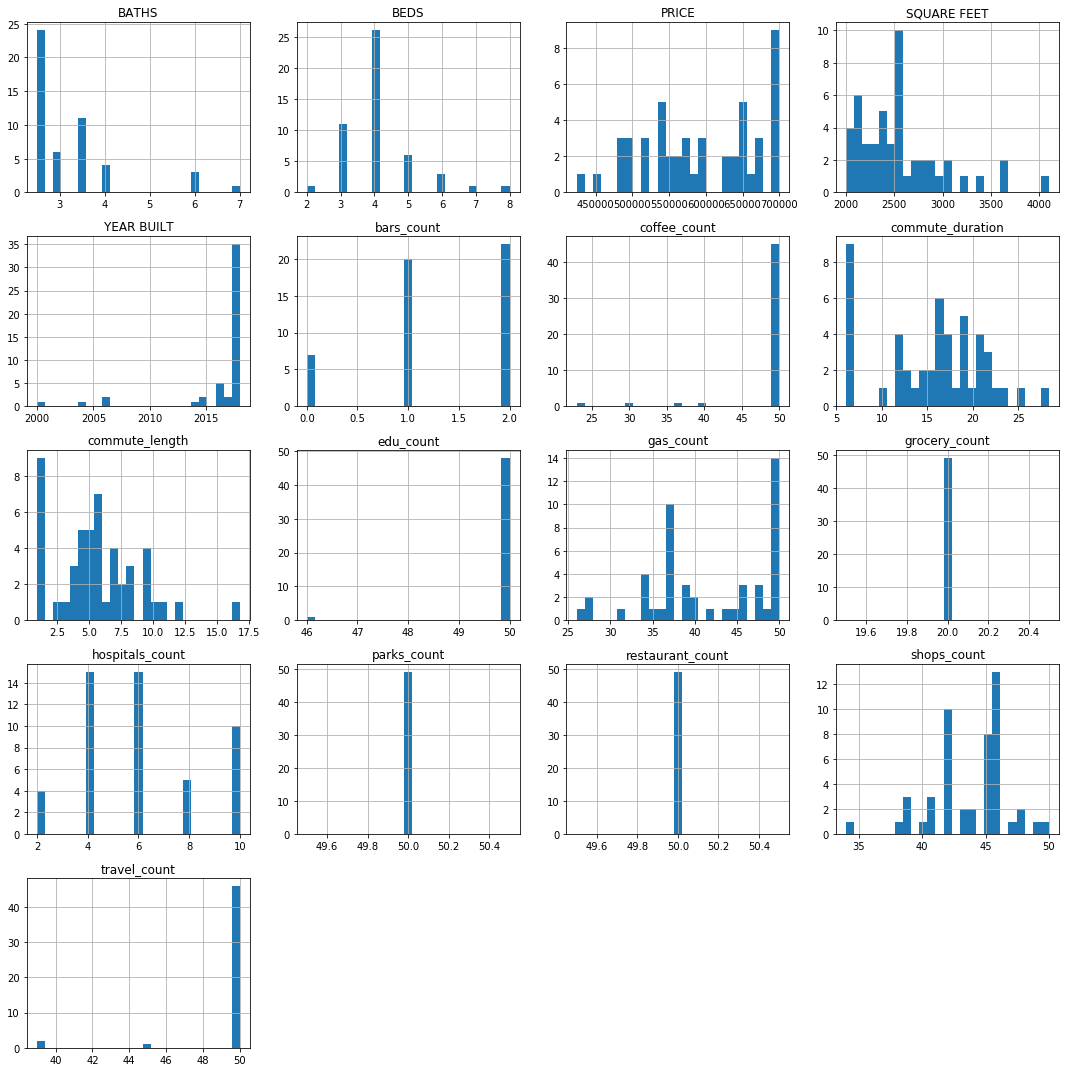

In [19]:
interesting_columns=['grocery_count', 'restaurant_count', 'hospitals_count', 'coffee_count',
       'bars_count', 'gas_count', 'shops_count', 'travel_count', 'parks_count',
       'edu_count', 'commute_length', 'commute_duration','PRICE','BEDS','BATHS','YEAR BUILT','SQUARE FEET']

ax_list = prop_df_sorted[interesting_columns].iloc[:49].hist(bins=25, layout=(5,4), figsize=(15,15))
plt.tight_layout()

### How is rank correlated with location properties of houses?
In the charts below we attempt to find if there exists a correlation between different facilities.

Text(0.5,1,'How is rank correlated with location properties of a house?')

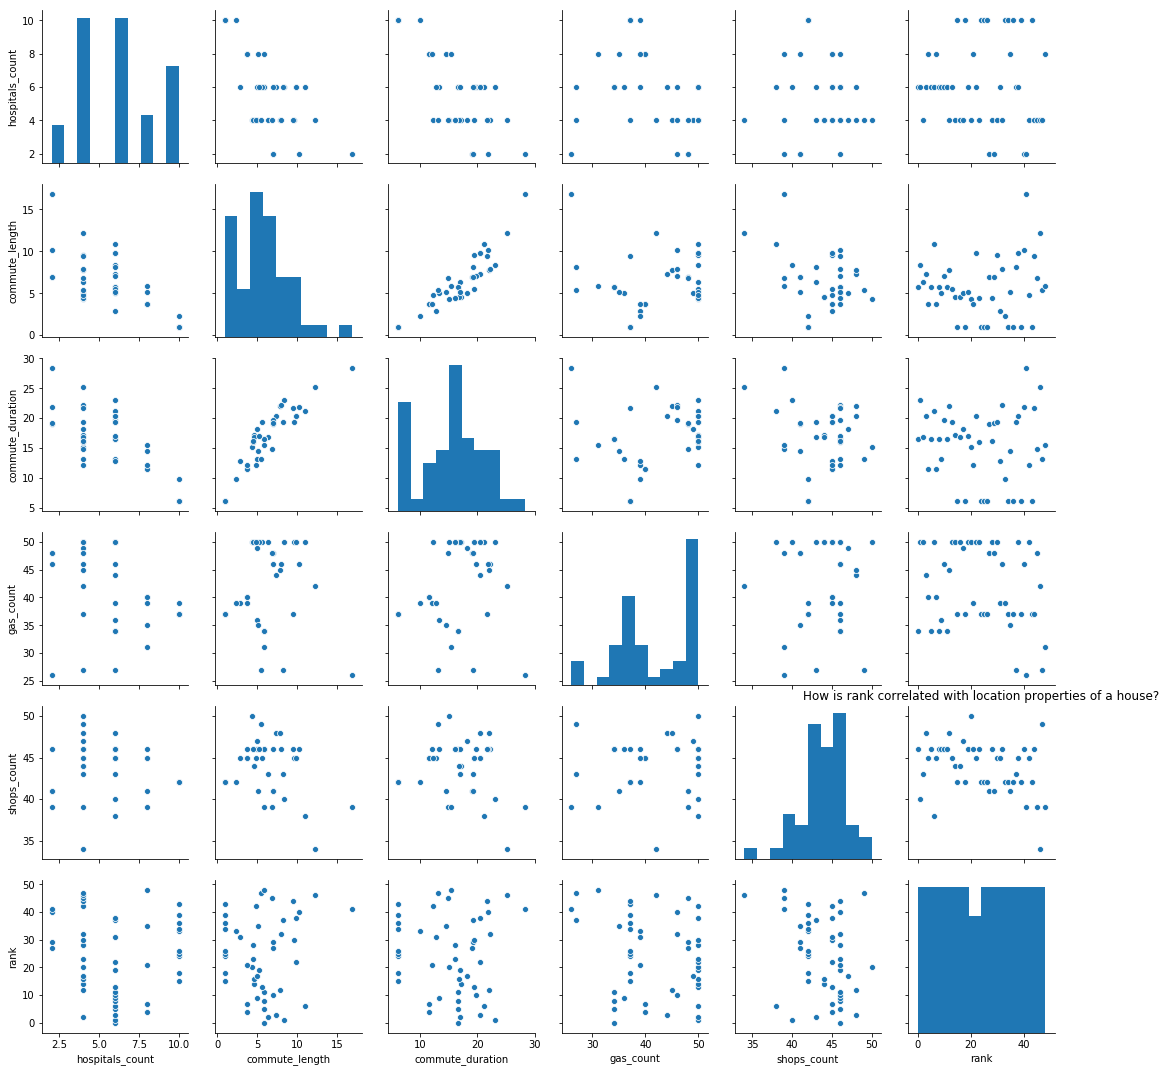

In [54]:
column_set1 = ['hospitals_count','commute_length','commute_duration',
               'gas_count', 'shops_count', 'rank']
column_set2 = ['rank','PRICE','BEDS','BATHS','YEAR BUILT','SQUARE FEET']

grd = sns.pairplot(data=prop_df_sorted[column_set1].iloc[:49])
plt.title('How is rank correlated with location properties of a house?')

### How is rank correlated with intrinsic properties of houses?

Text(0.5,1,'How is rank correlated with intrinsic properties of a house?')

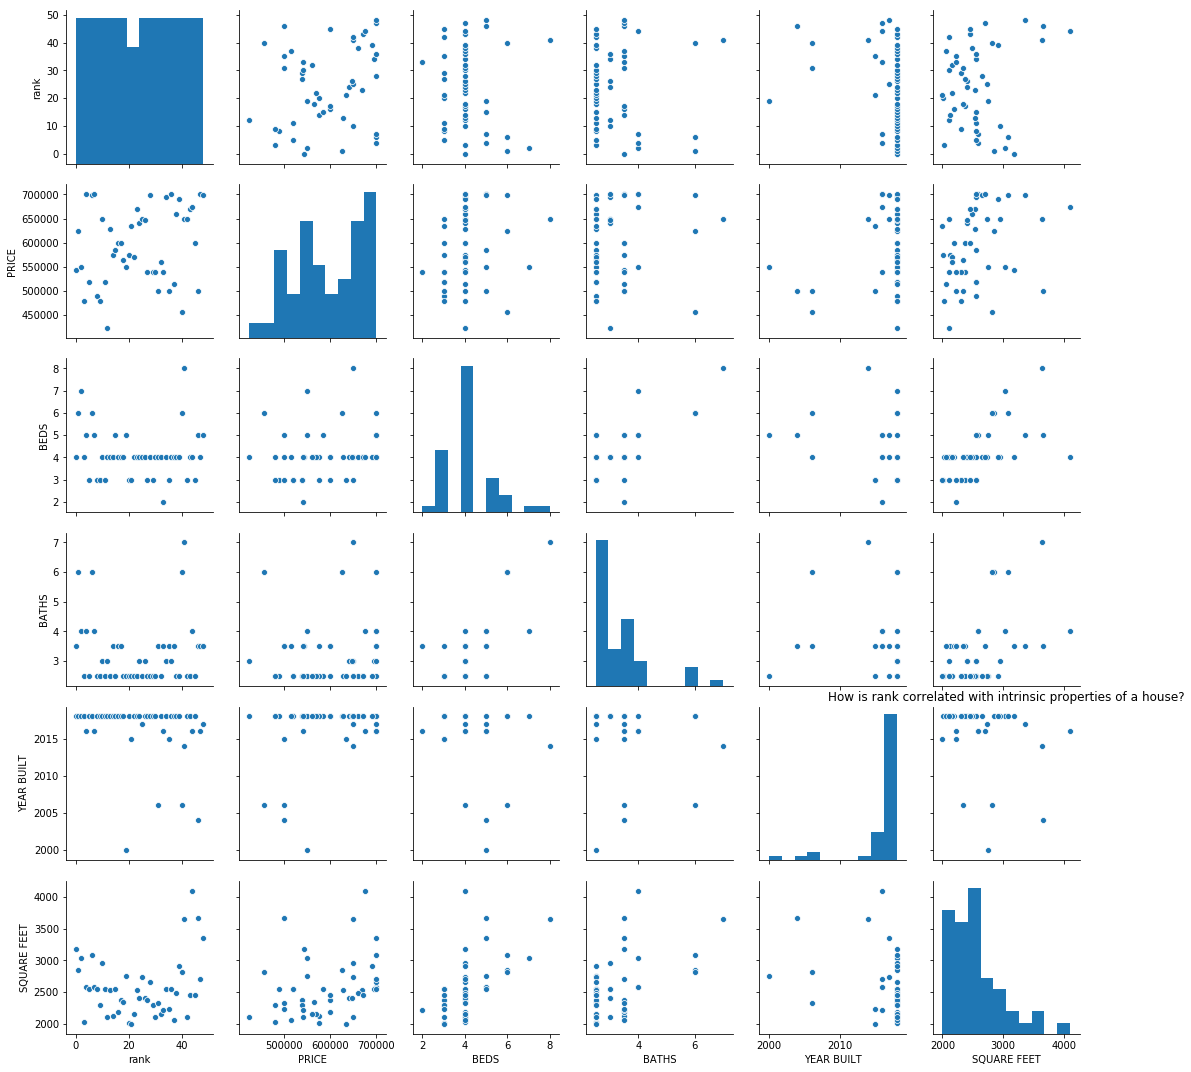

In [55]:
grd = sns.pairplot(data=prop_df_sorted[column_set2].iloc[:49])
plt.title('How is rank correlated with intrinsic properties of a house?')

### Save to disk

In [40]:
prop_df_sorted.to_csv('resources/houses_ranked.csv')
prop_df_sorted.spatial.to_featureclass('resources/shp/houses_ranked.shp')

'resources/shp/houses_ranked.shp'